<h3> Hello, cloud!</h3>

In [1]:
import pandas as pd
import numpy as np

In [2]:
! free m

              total        used        free      shared  buff/cache   available
Mem:       30873012      445416    30109448         916      318148    30052048
Swap:             0           0           0


In [3]:
 
df = pd.read_json('adidas2_tweets.json', encoding='utf-8')

In [4]:
text=df['text']

In [7]:
!pip3 install vaderSentiment

    100% |████████████████████████████████| 133kB 8.1MB/s eta 0:00:01


In [6]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/harambicloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def sent_to_words(sentences):
    for sent in sentences:       
        sent = re.sub('\"', "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [8]:
# Convert to list
data = text.values.tolist()

In [9]:
 # Build the bigram and trigram models
data_words = list(sent_to_words(data))
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [10]:
 # Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.039*"woman" + 0.033*"ift_tt" + 0.022*"add" + 0.021*"year" + '
  '0.021*"closet" + 0.019*"track" + 0.016*"announce" + 0.014*"list" + '
  '0.013*"next" + 0.012*"back"'),
 (1,
  '0.079*"shoe" + 0.022*"black" + 0.018*"still" + 0.016*"lol" + 0.014*"user" + '
  '0.013*"running" + 0.013*"friend" + 0.012*"song" + 0.012*"enjoy" + '
  '0.012*"chart"'),
 (2,
  '0.068*"adida" + 0.036*"beyonce" + 0.031*"check" + 0.025*"carbon" + '
  '0.023*"create" + 0.020*"buy" + 0.020*"code" + 0.018*"launch" + '
  '0.015*"roupa" + 0.015*"man"'),
 (3,
  '0.179*"com" + 0.127*"adida" + 0.100*"twitter" + 0.060*"http" + 0.041*"size" '
  '+ 0.039*"pic" + 0.031*"https" + 0.023*"new" + 0.011*"sale" + 0.011*"brand"'),
 (4,
  '0.335*"adida" + 0.020*"team" + 0.018*"style" + 0.018*"yeezy" + '
  '0.017*"yellow" + 0.015*"partnership" + 0.013*"price" + 0.011*"carbon" + '
  '0.011*"sneaker" + 0.009*"concept"')]


In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10) 

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.4490,"adida, team, style, yeezy, yellow, partnership...","[realise, wear, adida, sock, today, comfy, fit..."
1,1,4.0,0.4499,"adida, team, style, yeezy, yellow, partnership...","[realise, wear, adida, sock, today]"
2,2,1.0,0.4806,"shoe, black, still, lol, user, running, friend...","[pork, store, adida, favorite, song, gra]"
3,3,1.0,0.4805,"shoe, black, still, lol, user, running, friend...","[pork, store, adida, favorite, song, gra]"
4,4,4.0,0.4592,"adida, team, style, yeezy, yellow, partnership...","[check, store, mall, preliminary, glance]"
5,5,1.0,0.5994,"shoe, black, still, lol, user, running, friend...","[look, forward, check, adidas, store, hope, ca..."
6,6,4.0,0.5979,"adida, team, style, yeezy, yellow, partnership...",[adida]
7,7,1.0,0.6164,"shoe, black, still, lol, user, running, friend...","[wear, black, adida, suit, flourescent, green,..."
8,8,4.0,0.4491,"adida, team, style, yeezy, yellow, partnership...","[realise, wear, adida, sock, today, comfy, fit..."
9,9,4.0,0.4498,"adida, team, style, yeezy, yellow, partnership...","[realise, wear, adida, sock, today]"


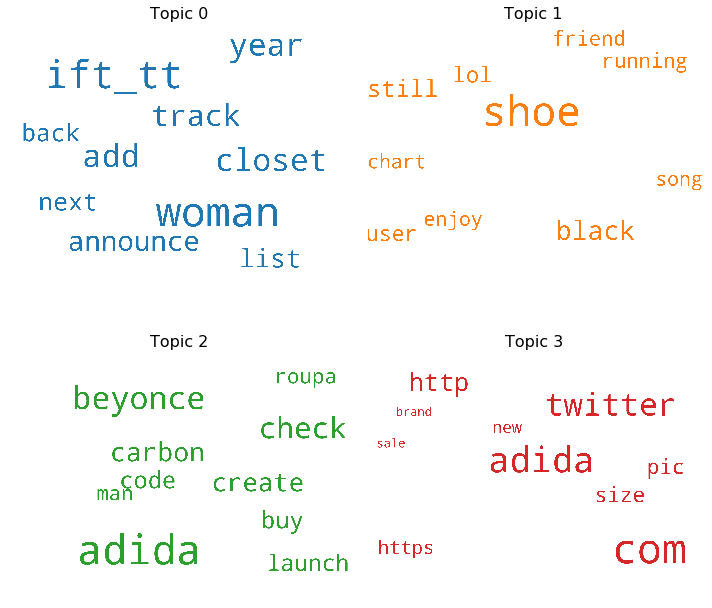

In [12]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/home/harambicloud/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.245080  0.110965       1        1  32.971199
1     -0.197765 -0.126653       2        1  19.086023
4      0.127291 -0.109135       3        1  18.627216
2      0.006771 -0.083503       4        1  16.312317
0     -0.181377  0.208326       5        1  13.003243, topic_info=     Category         Freq           Term        Total  loglift  logprob
0     Default  1516.000000          adida  1516.000000  30.0000  30.0000
36    Default   777.000000            com   777.000000  29.0000  29.0000
207   Default   432.000000        twitter   432.000000  28.0000  28.0000
27    Default   199.000000           shoe   199.000000  27.0000  27.0000
37    Default   261.000000           http   261.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
3000   Topic5    18.409748    sundaysport    23.387049   1.8007  -4.5306
2890   Topic5    16.182423  collaboration    23.447918   1.6691  -4.6595
1389   Topic5    14.152051           move    19.547737   1.7170  -4.7936
3002   Topic5     9.280635        野球用品専門店    12.089346   1.7756  -5.2155
3001   Topic5     9.280635       サンテースホーツ    12.089346   1.7756  -5.2155

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
673       5  0.974776       add
0         1  0.363272     adida
0         3  0.539963     adida
0         4  0.096257     adida
19        2  0.959622    adidas
...     ...       ...       ...
2999      3  0.886195       ypg
3001      1  0.165435  サンテースホーツ
3001      5  0.744457  サンテースホーツ
3002      1  0.165435   野球用品専門店
3002      5  0.744457   野球用品専門店

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1])

In [6]:
 text.to_csv("text.csv")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
pos=[]
comp=[]
neg=[]
neu=[]
for sentence in text:
    if sentence==None:
       pos.append(0.5)
       comp.append(0.5)
    else:
        vs = analyzer.polarity_scores(sentence)
 
        pos.append(vs['pos'])
        comp.append(vs['compound'])
        neu.append(vs['neu'])
        neg.append(vs['neg'])
        
        


In [22]:
df=pd.DataFrame({"twit":text,'positive':np.array(pos),
             'negative':np.array(neg),
             'neutral':np.array(neu),
             'compund':np.array(comp)}).to_csv('sentiments.csv')

In [16]:
np.mean(neg)

0.02626622296173045

In [17]:
np.mean(pos)

0.07601863560732114

In [19]:
np.mean(neu)

0.8977184692179699

In [21]:
np.mean(comp)

0.09818465890183027